In [1]:
!git clone https://github.com/abinthomasonline/alexnet-autoencoder.git
!pip install ipython-autotime
%load_ext autotime

Cloning into 'alexnet-autoencoder'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 7), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 24.50 MiB | 16.53 MiB/s, done.
Resolving deltas: 100% (7/7), done.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 338 µs (started: 2024-08-19 01:12:24 +00:00)


In [2]:
# !pip install -r /content/drive/MyDrive/alexnet-autoencoder/alexnet-autoencoder/requirements.txt

time: 284 µs (started: 2024-08-19 01:12:24 +00:00)


In [3]:
# Create the data directory if it doesn't already exist
!mkdir -p data

# Download the file with wget
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz -P data/

# Extract the contents of the .tgz file
!tar -xzf data/imagenette2.tgz -C data/

--2024-08-19 01:12:24--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.91.46, 52.217.83.102, 3.5.24.191, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.91.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘data/imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  30.5MB/s    in 48s     

2024-08-19 01:13:12 (30.9 MB/s) - ‘data/imagenette2.tgz’ saved [1557161267/1557161267]

time: 1min 5s (started: 2024-08-19 01:12:24 +00:00)


In [4]:
"""Autoencoder model for image compression using AlexNet as encoder"""
from torchvision.models import alexnet
from torchvision.models.alexnet import AlexNet_Weights
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = alexnet(weights=AlexNet_Weights.DEFAULT).features

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2),  # upsample
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(192, 192, kernel_size=3, stride=2),  # upsample
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.Conv2d(192, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),  # upsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=11, stride=4, padding=2, output_padding=1),  # upsample
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),

            nn.Conv2d(3, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


time: 7.32 s (started: 2024-08-19 01:13:29 +00:00)


#**نیازی به ترین قسمت زیر نیست چون زمان میبره تا ترین بشه**

In [5]:
"""Train the autoencoder model on the Imagenette dataset"""

import json
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# import torchvision


def train(*args, **kwargs):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    # Configs and Hyperparameters
    image_path = "/content/data/imagenette2"
    batch_size = 64
    learning_rate = 1e-3
    # momentum = 0.9
    epochs = 3
    steps_per_epoch = 100
    val_steps = 100
    early_stopping_patience = 10
    checkpoint_dir = "/content/alexnet-autoencoder/checkpoints"
    # os.mkdir(checkpoint_dir)
    checkpoint_interval = 10  # epochs
    best_checkpoint_path = os.path.join(checkpoint_dir, "best.pt")
    latest_checkpoint_path = os.path.join(checkpoint_dir, "latest.pt")

    # Data
    train_path = os.path.join(image_path, "train")
    val_path = os.path.join(image_path, "val")

    train_dataset = datasets.ImageFolder(
        train_path, transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ]))

    val_dataset = datasets.ImageFolder(
        val_path, transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ]))

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    # Model, Loss, Optimizer
    model = Autoencoder().to(device)
    loss_fn = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize training variables
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    metrics = {"epoch": [], "train": [], "eval": []}
    epoch = -1
    best_val_loss = np.inf
    early_stopping_counter = 0

    # Load from checkpoint if exists
    if os.path.exists(latest_checkpoint_path):
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch'] - 1
        early_stopping_counter = checkpoint["early_stopping_counter"]

    # Save zeroth epoch checkpoint for plotting
    if epoch == -1:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict()
        }, os.path.join(checkpoint_dir, f"epoch_{epoch + 1}.pt"))

    # Training loop
    while (epoch + 1) < epochs:
        epoch += 1
        print(epoch)
        # Early stopping
        # if early_stopping_counter == early_stopping_patience:
        #     print("Stopping Criterion Met.. ")
        #     break

        # Train
        model.train()
        train_losses = torch.zeros(steps_per_epoch, device=device)
        for i in range(steps_per_epoch):
            try:
                images, _ = next(train_iter)
                images = images.to(device)
            except StopIteration:
                train_iter = iter(train_loader)
                images, _ = next(train_iter)
                images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            train_losses[i] = loss

        # Eval
        model.eval()
        val_losses = torch.zeros(val_steps, device=device)
        with torch.no_grad():
            for i in range(val_steps):
                try:
                    images, _ = next(val_iter)
                    images = images.to(device)
                except StopIteration:
                    val_iter = iter(val_loader)
                    images, _ = next(val_iter)
                    images = images.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, images)
                val_losses[i] = loss

        metrics["epoch"].append(epoch + 1)
        metrics["train"].append(train_losses.mean().item())
        metrics["eval"].append(val_losses.mean().item())

        # Save best model
        if metrics["eval"][-1] <= best_val_loss:
            best_val_loss = metrics["eval"][-1]
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'loss': best_val_loss,
            }, best_checkpoint_path)
        else:
            early_stopping_counter += 1

        # Save recent checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'loss': metrics["eval"][-1],
            'early_stopping_counter': early_stopping_counter
        }, latest_checkpoint_path)

        # Save checkpoint every n epochs
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'loss': metrics["eval"][-1],
                'early_stopping_counter': early_stopping_counter
            }, os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pt"))

        print("Epoch: {}/{}.. ".format(metrics["epoch"][-1], epochs),
              "Training Loss: {:.3f}.. ".format(metrics["train"][-1]),
              "Validation Loss: {:.3f}.. ".format(metrics["eval"][-1]),
              "Early Stopping Counter: {}/{}.. ".format(early_stopping_counter, early_stopping_patience))

    # Save metrics
    with open(os.path.join(checkpoint_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f)


if __name__ == "__main__":
    train()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 52.6MB/s]


0
Epoch: 1/3..  Training Loss: 0.995..  Validation Loss: 0.630..  Early Stopping Counter: 0/10.. 
1
Epoch: 2/3..  Training Loss: 0.489..  Validation Loss: 0.451..  Early Stopping Counter: 0/10.. 
2
Epoch: 3/3..  Training Loss: 0.402..  Validation Loss: 0.401..  Early Stopping Counter: 0/10.. 
time: 3min 54s (started: 2024-08-19 01:13:37 +00:00)


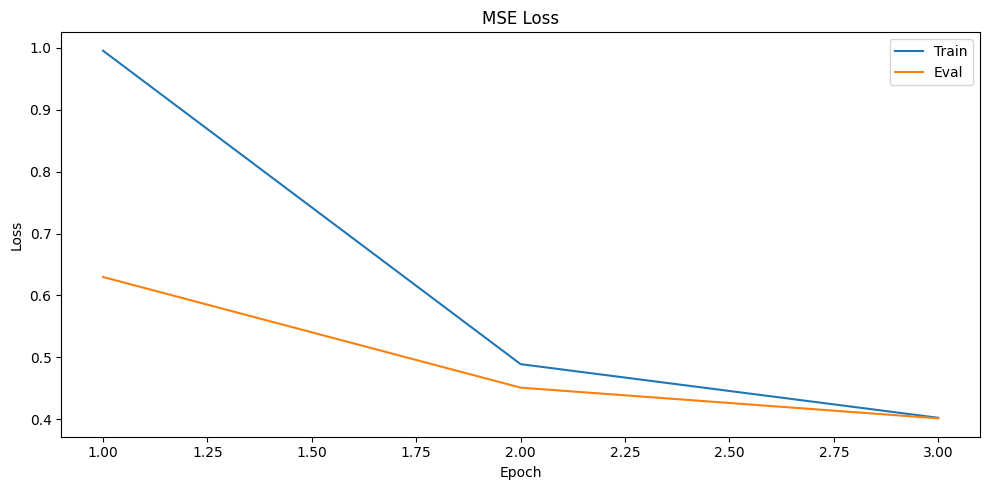

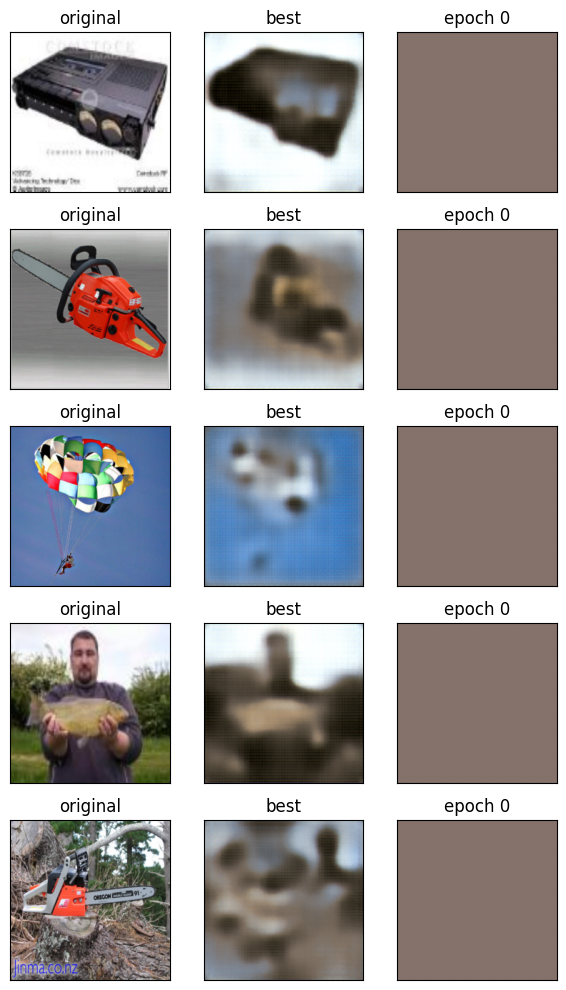

time: 2.86 s (started: 2024-08-19 01:17:31 +00:00)


In [6]:
"""Plot metrics and images"""

import json
import os

import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms



def plot(*args, **kwargs):

    # Configs
    checkpoint_dir = "/content/alexnet-autoencoder/checkpoints"
    plots_dir = "plots"
    metrics_path = os.path.join(checkpoint_dir, "metrics.json")
    num_images = 5
    best_checkpoint_path = os.path.join(checkpoint_dir, "best.pt")

    # Load metrics
    with open(metrics_path, "r") as f:
        metrics = json.load(f)

    # Plot metrics
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(metrics["epoch"], metrics["train"], label="Train")
    ax.plot(metrics["epoch"], metrics["eval"], label="Eval")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("MSE Loss")
    ax.legend()
    fig.tight_layout()
    # fig.savefig(os.path.join(plots_dir, "loss.png"))

    # Data
    image_path = "/content/data/imagenette2"
    val_path = os.path.join(image_path, "val")
    val_dataset = datasets.ImageFolder(
        val_path, transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ]))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=num_images, shuffle=True)
    images, _ = next(iter(val_loader))

    # Model
    model = Autoencoder()
    inverse_transform = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

    # Original images
    original_images = torch.clamp(inverse_transform(images), 0, 1)

    # Best checkpoint
    checkpoint = torch.load(best_checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    with torch.no_grad():
        best_reconstructions = model(images)
    best_reconstructions = torch.clamp(inverse_transform(best_reconstructions), 0, 1)

    # checkpoints
    intermediate_reconstructions = []
    epochs = sorted([int(filename.split(".")[0].split("_")[1])
                     for filename in os.listdir(checkpoint_dir)
                     if filename.startswith("epoch_") and filename.endswith(".pt")], reverse=True)
    for epoch in epochs:
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        with torch.no_grad():
            reconstructions = model(images)
        reconstructions = torch.clamp(inverse_transform(reconstructions), 0, 1)
        intermediate_reconstructions.append(reconstructions)

    # Plot
    n_rows = num_images
    n_cols = len([original_images, best_reconstructions] + intermediate_reconstructions)
    img_size = 2
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*img_size, n_rows*img_size))
    for i in range(n_rows):
        # Original images
        ax[i][0].imshow(torch.permute(original_images[i], (1, 2, 0)))
        ax[i][0].get_xaxis().set_visible(False)
        ax[i][0].get_yaxis().set_visible(False)
        ax[i][0].set_title("original")

        # Best reconstructions
        ax[i][1].imshow(torch.permute(best_reconstructions[i], (1, 2, 0)))
        ax[i][1].get_xaxis().set_visible(False)
        ax[i][1].get_yaxis().set_visible(False)
        ax[i][1].set_title("best")

        # Intermediate reconstructions
        for j, epoch in enumerate(epochs):
            intermediate_reconstruction = intermediate_reconstructions[j]
            ax[i][j + 2].imshow(torch.permute(intermediate_reconstruction[i], (1, 2, 0)))
            ax[i][j + 2].get_xaxis().set_visible(False)
            ax[i][j + 2].get_yaxis().set_visible(False)
            ax[i][j + 2].set_title(f"epoch {epoch}")
    fig.tight_layout()
    # fig.savefig(os.path.join(plots_dir, "reconstructions.png"))


if __name__ == "__main__":
    plot()


#**حتما باید این قسمت رو ران کنید تا وزن های مدل آپدیت بشند**


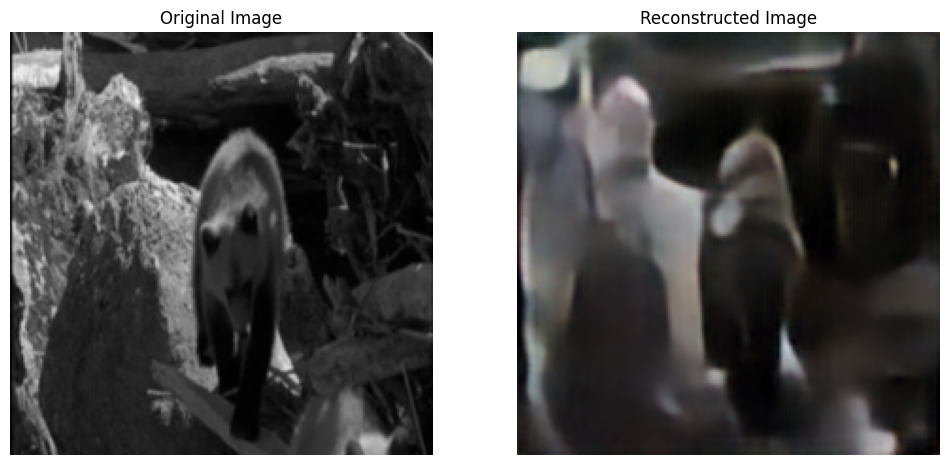

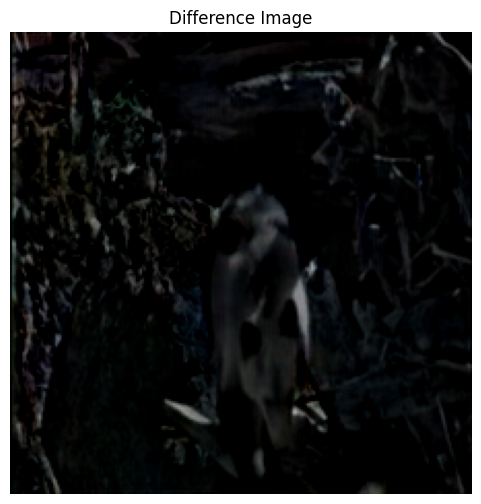

time: 1.65 s (started: 2024-08-19 01:37:09 +00:00)


In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image
img_path = "/content/12(1).jpeg"

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and transform the image
img = Image.open(img_path).convert("L")  # Convert to RGB to match training data format
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

# Load the model and weights
model = Autoencoder()
checkpoint = torch.load("/content/alexnet-autoencoder/checkpoints/best.pt", map_location=torch.device('cpu'))  # Adjust device if using GPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Perform inference
with torch.no_grad():
    reconstruction = model(img_transformed)

# Inverse normalize the output image for display
inverse_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
img_reconstructed = inverse_transform(reconstruction.squeeze(0))  # Remove batch dimension
img_reconstructed = torch.clamp(img_reconstructed, 0, 1)

import numpy as np

# Assuming the inverse normalization definition is correct
# Helper function to undo normalization for display
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)    # The inverse of normalization
    return tensor

# Apply inverse normalization to the transformed original image for visualization
img_transformed_vis = inverse_normalize(img_transformed.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_transformed_vis = img_transformed_vis.permute(1, 2, 0)  # Rearrange dimensions to HxWxC
img_transformed_vis = torch.clamp(img_transformed_vis, 0, 1)  # Ensure the pixel values are valid

# Plotting
plt.figure(figsize=(12, 6))

# Display the original image (after undoing the transformations for visualization purposes)
plt.subplot(1, 2, 1)
plt.imshow(img_transformed_vis.numpy())
plt.title("Original Image")
plt.axis('off')

# Display the reconstructed image (already correctly handled)
plt.subplot(1, 2, 2)
# No need for additional permute or .cpu() as it's already handled correctly
plt.imshow(img_reconstructed.permute(1, 2, 0).numpy())
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()


# Path to the image
img_path = "/content/12(2).jpeg"

# Load and transform the image
img = Image.open(img_path).convert("L")  # Convert to RGB to match training data format
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

# Apply inverse normalization to the transformed original image for visualization
img_transformed_vis = inverse_normalize(img_transformed.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_transformed_vis = img_transformed_vis.permute(1, 2, 0)  # Rearrange dimensions to HxWxC
img_transformed_vis = torch.clamp(img_transformed_vis, 0, 1)  # Ensure the pixel values are valid

# img_reconstructed is already in the correct format (C, H, W) and range [0, 1] after clamping
# img_transformed_vis was intended for visualization and is a numpy array in (H, W, C) format

# Convert img_transformed_vis back to a PyTorch tensor and ensure it's in (C, H, W) format for subtraction
img_transformed_vis_tensor = torch.from_numpy(img_transformed_vis.numpy()).permute(2, 0, 1)

# Both tensors should now be in the (C, H, W) format; ensure they're on the same device
img_transformed_vis_tensor = img_transformed_vis_tensor.to("cpu")  # Adjust this as necessary
img_reconstructed = img_reconstructed.to("cpu")  # Ensure this matches your device context

# Perform the subtraction. Now that dimensions and devices match, this should work without error
image_diff = img_transformed_vis_tensor - img_reconstructed

# Clamp the result to ensure it's within a valid range for visualization
image_diff_clamped = torch.clamp(image_diff, 0, 1)

# For visualization, convert back to (H, W, C) format
image_diff_np = image_diff_clamped.permute(1, 2, 0).numpy()

# Plotting the difference image
plt.figure(figsize=(6, 6))
plt.imshow(image_diff_np)
plt.title("Difference Image")
plt.axis('off')
plt.show()


In [9]:
# !pip install torchviz

import torch
import torchvision.models as models
# from torchviz import make_dot

# model = Autoencoder()
# state_dict = model.state_dict()

# Access weights
for name, param in model.named_parameters():
    print(f"Layer {name} has weights of shape {param.size()}")

Layer encoder.0.weight has weights of shape torch.Size([64, 3, 11, 11])
Layer encoder.0.bias has weights of shape torch.Size([64])
Layer encoder.3.weight has weights of shape torch.Size([192, 64, 5, 5])
Layer encoder.3.bias has weights of shape torch.Size([192])
Layer encoder.6.weight has weights of shape torch.Size([384, 192, 3, 3])
Layer encoder.6.bias has weights of shape torch.Size([384])
Layer encoder.8.weight has weights of shape torch.Size([256, 384, 3, 3])
Layer encoder.8.bias has weights of shape torch.Size([256])
Layer encoder.10.weight has weights of shape torch.Size([256, 256, 3, 3])
Layer encoder.10.bias has weights of shape torch.Size([256])
Layer decoder.0.weight has weights of shape torch.Size([256, 256, 3, 3])
Layer decoder.0.bias has weights of shape torch.Size([256])
Layer decoder.1.weight has weights of shape torch.Size([256])
Layer decoder.1.bias has weights of shape torch.Size([256])
Layer decoder.3.weight has weights of shape torch.Size([256, 256, 3, 3])
Layer de

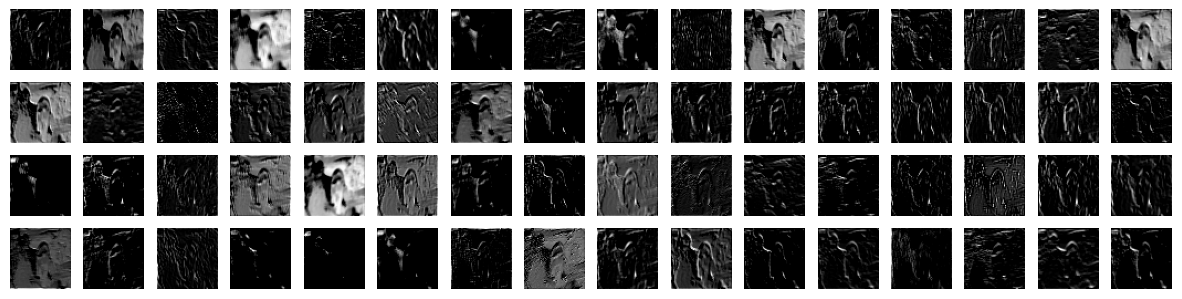

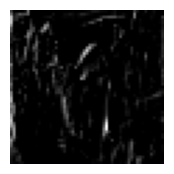

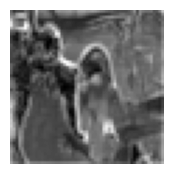

time: 5.69 s (started: 2024-08-19 01:37:22 +00:00)


In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and transform the image
img_path = "/content/12(1).jpeg"
# img_path = "/content/008 (1).jpeg"
img = Image.open(img_path).convert("L")  # Convert to RGB to match training data format
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

# Load the model and weights
model = Autoencoder()
checkpoint = torch.load("/content/alexnet-autoencoder/checkpoints/best.pt", map_location=torch.device('cpu'))  # Adjust device if using GPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Hook to capture the output of the first layer
first_layer_output = []

def hook_fn(module, input, output):
    first_layer_output.append(output)

# Register the hook
first_layer = model.encoder[0]  # Adjust based on the first layer in your model
hook = first_layer.register_forward_hook(hook_fn)

# Perform inference
with torch.no_grad():
    _ = model(img_transformed)

# Remove the hook
hook.remove()

# Extract the output of the first layer
first_layer_output = first_layer_output[0]

# Normalize the output for visualization
first_layer_output = first_layer_output.squeeze(0)  # Remove batch dimension
first_layer_output = first_layer_output.permute(1, 2, 0)  # Rearrange dimensions to HxWxC

# Plot the output of the first layer
plt.figure(figsize=(15, 15))
num_filters = first_layer_output.shape[2]
for i in range(num_filters):
    plt.subplot(16, 16, i + 1)  # Assuming 256 filters for 16x16 grid
    plt.imshow(first_layer_output[:, :, i].cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()


# Plot the output of the first layer
plt.figure(figsize=(2, 2))
num_filters = first_layer_output.shape[2]
for i in range(1):
    plt.subplot(1, 1, i + 1)  # Assuming 256 filters for 16x16 grid
    plt.imshow(first_layer_output[:, :, i].cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

mean_output = np.mean(first_layer_output.cpu().numpy(), axis=2)
# Plot the output of the first layer
plt.figure(figsize=(2, 2))
num_filters = first_layer_output.shape[2]
for i in range(1):
    plt.subplot(1, 1, i + 1)  # Assuming 256 filters for 16x16 grid
    plt.imshow(mean_output, cmap='gray')
    plt.axis('off')

plt.show()

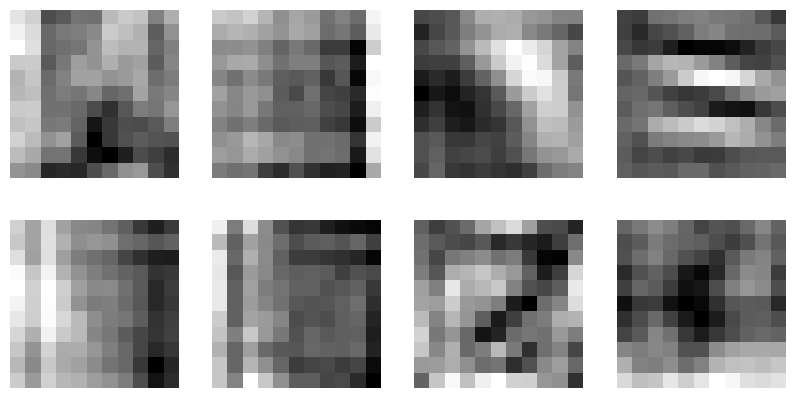

time: 276 ms (started: 2024-08-19 01:37:28 +00:00)


In [12]:
from PIL import Image
import matplotlib.pyplot as plt


first_layer_weights = model.encoder[0].weight.data.cpu().numpy()


fig, ax = plt.subplots(2, 4, figsize=(10, 5))
# for i in range(8):
#     ax[i].imshow(first_layer_weights[i, 0], cmap='gray')
#     ax[i].axis('off')
# plt.show()
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(first_layer_weights[i * 4 + j, 0], cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [13]:
print(model.decoder[24].bias.data)

tensor([-0.6305,  0.7463, -0.7605])
time: 22.1 ms (started: 2024-08-19 01:37:28 +00:00)


In [14]:
# Manually get the parameters from the specific layers
encoder_layer_0_weights = model.encoder[0].weight.data
encoder_layer_0_biases = model.encoder[0].bias.data
decoder_layer_18_weights = model.decoder[18].weight.data
decoder_layer_18_biases = model.decoder[18].bias.data
decoder_layer_19_weights = model.decoder[19].weight.data
decoder_layer_19_biases = model.decoder[19].bias.data
decoder_layer_21_weights = model.decoder[21].weight.data
decoder_layer_21_biases = model.decoder[21].bias.data
decoder_layer_22_weights = model.decoder[22].weight.data
decoder_layer_22_biases = model.decoder[22].bias.data
decoder_layer_24_weights = model.decoder[24].weight.data
decoder_layer_24_biases = model.decoder[24].bias.data

# Manually create a dictionary to store them
custom_layers_dict = {
    'encoder.0.weight': encoder_layer_0_weights,
    'encoder.0.bias': encoder_layer_0_biases,
    'decoder.18.weight': decoder_layer_18_weights,
    'decoder.18.bias': decoder_layer_18_biases,
    'decoder.19.weight': decoder_layer_19_weights,
    'decoder.19.bias': decoder_layer_19_biases,
    'decoder.21.weight': decoder_layer_21_weights,
    'decoder.21.bias': decoder_layer_21_biases,
    'decoder.22.weight': decoder_layer_22_weights,
    'decoder.22.bias': decoder_layer_22_biases,
    'decoder.24.weight': decoder_layer_24_weights,
    'decoder.24.bias': decoder_layer_24_biases
}

# Save the manually created dictionary
torch.save(custom_layers_dict, 'selected_layers_manual.pth')


time: 5.68 ms (started: 2024-08-19 01:37:28 +00:00)


In [15]:
loaded_layers = torch.load('selected_layers_manual.pth')


for layer_name, tensor in loaded_layers.items():
    print(f"Layer {layer_name} has weights/biases of shape {tensor.size()}")

Layer encoder.0.weight has weights/biases of shape torch.Size([64, 3, 11, 11])
Layer encoder.0.bias has weights/biases of shape torch.Size([64])
Layer decoder.18.weight has weights/biases of shape torch.Size([64, 64, 3, 3])
Layer decoder.18.bias has weights/biases of shape torch.Size([64])
Layer decoder.19.weight has weights/biases of shape torch.Size([64])
Layer decoder.19.bias has weights/biases of shape torch.Size([64])
Layer decoder.21.weight has weights/biases of shape torch.Size([64, 3, 11, 11])
Layer decoder.21.bias has weights/biases of shape torch.Size([3])
Layer decoder.22.weight has weights/biases of shape torch.Size([3])
Layer decoder.22.bias has weights/biases of shape torch.Size([3])
Layer decoder.24.weight has weights/biases of shape torch.Size([3, 3, 3, 3])
Layer decoder.24.bias has weights/biases of shape torch.Size([3])
time: 6.46 ms (started: 2024-08-19 01:37:28 +00:00)


In [16]:
import torch
import torch.nn as nn

class PartialAutoencoder(nn.Module):
    def __init__(self):
        super(PartialAutoencoder, self).__init__()
        self.layer0 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)  # Adjusting this to output 64 channels
        self.intermediate = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),  # upsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=11, stride=4, padding=2, output_padding=1),  # upsample
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            # nn.Conv2d(3, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.intermediate(x)
        return x

time: 1.06 ms (started: 2024-08-19 01:37:28 +00:00)


In [17]:
# Initialize the model
new_model = PartialAutoencoder()

print(new_model)

PartialAutoencoder(
  (layer0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (intermediate): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)
time: 3.83 ms (started: 2024-08-19 01:37:28 +00:00)


In [18]:
# Load the saved weights
weights_path = 'selected_layers_manual.pth'
loaded_weights = torch.load(weights_path)


# Manually load the weights into the new model's layers
new_model.layer0.weight.data = loaded_weights['encoder.0.weight']
new_model.layer0.bias.data = loaded_weights['encoder.0.bias']

new_model.intermediate[0].weight.data = loaded_weights['decoder.18.weight']
new_model.intermediate[0].bias.data = loaded_weights['decoder.18.bias']
new_model.intermediate[1].weight.data = loaded_weights['decoder.19.weight']
new_model.intermediate[1].bias.data = loaded_weights['decoder.19.bias']
new_model.intermediate[3].weight.data = loaded_weights['decoder.21.weight']
new_model.intermediate[3].bias.data = loaded_weights['decoder.21.bias']
new_model.intermediate[4].weight.data = loaded_weights['decoder.22.weight']
new_model.intermediate[4].bias.data = loaded_weights['decoder.22.bias']
# new_model.intermediate[6].weight.data = loaded_weights['decoder.24.weight']
# new_model.intermediate[6].bias.data = loaded_weights['decoder.24.bias']

time: 3.42 ms (started: 2024-08-19 01:37:28 +00:00)


In [19]:
import torchvision.transforms as transforms
from PIL import Image

# Load the image
img_path = "/content/12(1).jpeg"
img_path2 = "/content/12(2).jpeg"
# img_path = "/content/008 (1).jpeg"
# img_path2 = "/content/008 (2).jpeg"


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open(img_path).convert("L")
img_transformed_img1 = transform(img)
img_transformed_img1_unsqueeze = img_transformed_img1.unsqueeze(0)


# Pass the input through the new model
output = new_model(img_transformed_img1_unsqueeze)
print(output.shape)


# # print model
# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.render('autoencoder_graph', format='png')

torch.Size([1, 3, 872, 872])
time: 236 ms (started: 2024-08-19 01:37:28 +00:00)


(224, 224)


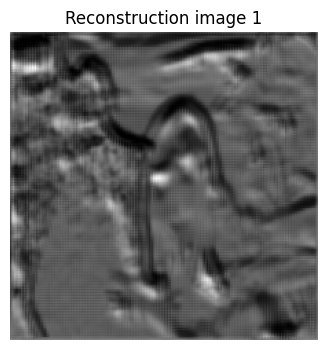

time: 199 ms (started: 2024-08-19 01:37:28 +00:00)


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# Denormalization
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

def denormalize(tensor):
    return tensor * std + mean


output_denorm = (output)


resize = transforms.Resize((224, 224))
output_resized = resize(output_denorm)


# Convert output to CPU and numpy for plotting
output_np = output_resized.squeeze().cpu().detach().numpy()
output_np_transpose = output_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

# Choose one channel to visualize as grayscale
grayscale_image = output_np_transpose
print(np.shape(grayscale_image[:,:,0]))

plt.figure(figsize=(4, 4))
plt.imshow(grayscale_image[:,:,0], cmap='gray')
plt.title("Reconstruction image 1")
plt.axis('off')
plt.show()

Image 1 (224, 224)
Image 2 (224, 224, 1)
Reconstruction image 1 (224, 224)
Difference img2 & img1 (224, 224)


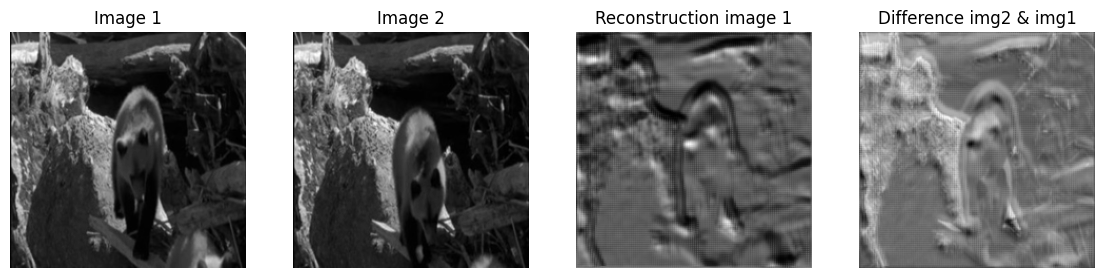

time: 417 ms (started: 2024-08-19 01:37:29 +00:00)


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


img = Image.open(img_path2).convert("L")
img_transformed = transform(img)

img_transformed = torch.clamp(img_transformed, 0, 1).permute(1, 2, 0).numpy()

###########
image_diff = img_transformed - grayscale_image


print('Image 1', np.shape(img_transformed_img1.permute(1, 2, 0).numpy()[:, :, 0],))
print("Image 2", np.shape(img_transformed))
print("Reconstruction image 1", np.shape(grayscale_image[:,:,0]))
print("Difference img2 & img1", np.shape(image_diff[:,:,0]))

plt.subplots(1, 4, figsize=(14, 8))

plt.subplot(1, 4, 1)
plt.imshow(img_transformed_img1.permute(1, 2, 0).numpy()[:, :, 0], cmap='gray')
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_transformed, cmap='gray')
plt.title("Image 2")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(grayscale_image[:,:,0], cmap='gray')
plt.title("Reconstruction image 1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_diff[:,:,0], cmap='gray')
plt.title("Difference img2 & img1")
plt.axis('off')

plt.show()

# **Images Correlation images**


In [23]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


# Resize function
def resize_image(image, size=(255, 255)):
    return cv2.resize(image, size)

# Correlation calculation function
def calculate_correlation(image1, image2):
    # Ensure the images are resized
    image1_resized = resize_image(image1)
    image2_resized = resize_image(image2)

    # Flatten the images
    vector1 = image1_resized.flatten()
    vector2 = image2_resized.flatten()

    # Calculate Pearson correlation coefficient
    correlation = np.corrcoef(vector1, vector2)[0, 1]
    return correlation

def denormalize(tensor):
    return tensor * std + mean


correlation = []

!unzip '/content/animals.zip'
!unzip '/content/nonanimals.zip'


for j in range(1,7):

  for i in range(1, 103):

    print(j, '---', i)

    if j < 4:
      if i < 10:
        img_path = f'/content/animals/{i}/00{i} ({j}).jpeg'
      elif i < 100:
        img_path = f'/content/animals/{i}/0{i} ({j}).jpeg'
      else:
        img_path = f'/content/animals/{i}/{i} ({j}).jpeg'
    else:
      if i < 10:
        img_path = f'/content/nonanimals/{i}/00{i} ({j-3}).jpeg'
      elif i < 100:
        img_path = f'/content/nonanimals/{i}/0{i} ({j-3}).jpeg'
      else:
        img_path = f'/content/nonanimals/{i}/{i} ({j-3}).jpeg'


    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(img_path).convert("L")
    img_transformed_img1 = transform(img)
    img_transformed_img1_unsqueeze = img_transformed_img1.unsqueeze(0)


    # Pass the input through the new model
    output = new_model(img_transformed_img1_unsqueeze)


    # Denormalization
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

    output_denorm = (output)


    resize = transforms.Resize((224, 224))
    output_resized = resize(output_denorm)


    # Convert output to CPU and numpy for plotting
    output_np = output_resized.squeeze().cpu().detach().numpy()
    output_np_transpose = output_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

    # Choose one channel to visualize as grayscale
    grayscale_image = output_np_transpose




    # Convert reconstructed image to uint8 for compatibility with OpenCV
    reconstructed_image1_uint8 = cv2.normalize(grayscale_image[:,:,0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Read the second image using OpenCV
    image2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Calculate the correlation
    correlation.append(calculate_correlation(reconstructed_image1_uint8, image2))



print(f'Mean Correlation between the two images: {np.mean(correlation)}')
print(f'Std Correlation between the two images: {np.std(correlation)}')

Archive:  /content/animals.zip
   creating: animals/1/
  inflating: animals/1/001 (1).jpeg  
  inflating: animals/1/001 (2).jpeg  
  inflating: animals/1/001 (3).jpeg  
   creating: animals/10/
  inflating: animals/10/010 (1).jpeg  
  inflating: animals/10/010 (2).jpeg  
  inflating: animals/10/010 (3).jpeg  
   creating: animals/100/
  inflating: animals/100/100 (1).jpeg  
  inflating: animals/100/100 (2).jpeg  
  inflating: animals/100/100 (3).jpeg  
   creating: animals/101/
  inflating: animals/101/101 (1).jpeg  
  inflating: animals/101/101 (2).jpeg  
  inflating: animals/101/101 (3).jpeg  
   creating: animals/102/
  inflating: animals/102/102 (1).jpeg  
  inflating: animals/102/102 (2).jpeg  
  inflating: animals/102/102 (3).jpeg  
   creating: animals/11/
  inflating: animals/11/011 (1).jpeg  
  inflating: animals/11/011 (2).jpeg  
  inflating: animals/11/011 (3).jpeg  
   creating: animals/12/
  inflating: animals/12/012 (1).jpeg  
  inflating: animals/12/012 (2).jpeg  
  infl